smart_hans_07312022_173453_4_131-155_08_mnn_.csv
smart_hans_07312022_171736_10_271-296_08_mnn_.csv
smart_hans_08022022_182936_5_185-215_08_wny_.csv
smart_hans_08022022_211852_10_341-371_08_mky_.csv
smart_hans_07312022_182331_4_149-180_08_wnn_.csv
smart_hans_08022022_190740_9_301-331_08_mny_.csv
smart_hans_07312022_181701_7_243-273_08_wny_.csv
smart_hans_07252022_154619_12_431-469_08_mgy_.csv
smart_hans_08022022_192941_6_217-247_08_wny_.csv
smart_hans_07312022_173105_12_400-431_08_mnn_.csv
smart_hans_07312022_175436_12_339-368_08_mny_.csv
smart_hans_08022022_192131_8_280-310_08_wny_.csv
smart_hans_07312022_161925_10_313-339_08_mny_.csv
smart_hans_08022022_191248_9_307-336_08_mny_.csv
smart_hans_08022022_192219_4_154-184_08_wny_person_hat_nach_12_gewackelt.csv
smart_hans_08022022_174636_13_433-463_08_wyn_.csv
smart_hans_07252022_154808_9_313-351_08_mny_.csv
smart_hans_07312022_170216_4_149-178_08_mgy_furz_lachen_am_ende.csv
smart_hans_08022022_195007_9_312-344_08_gny_.csv
smart_hans_0802

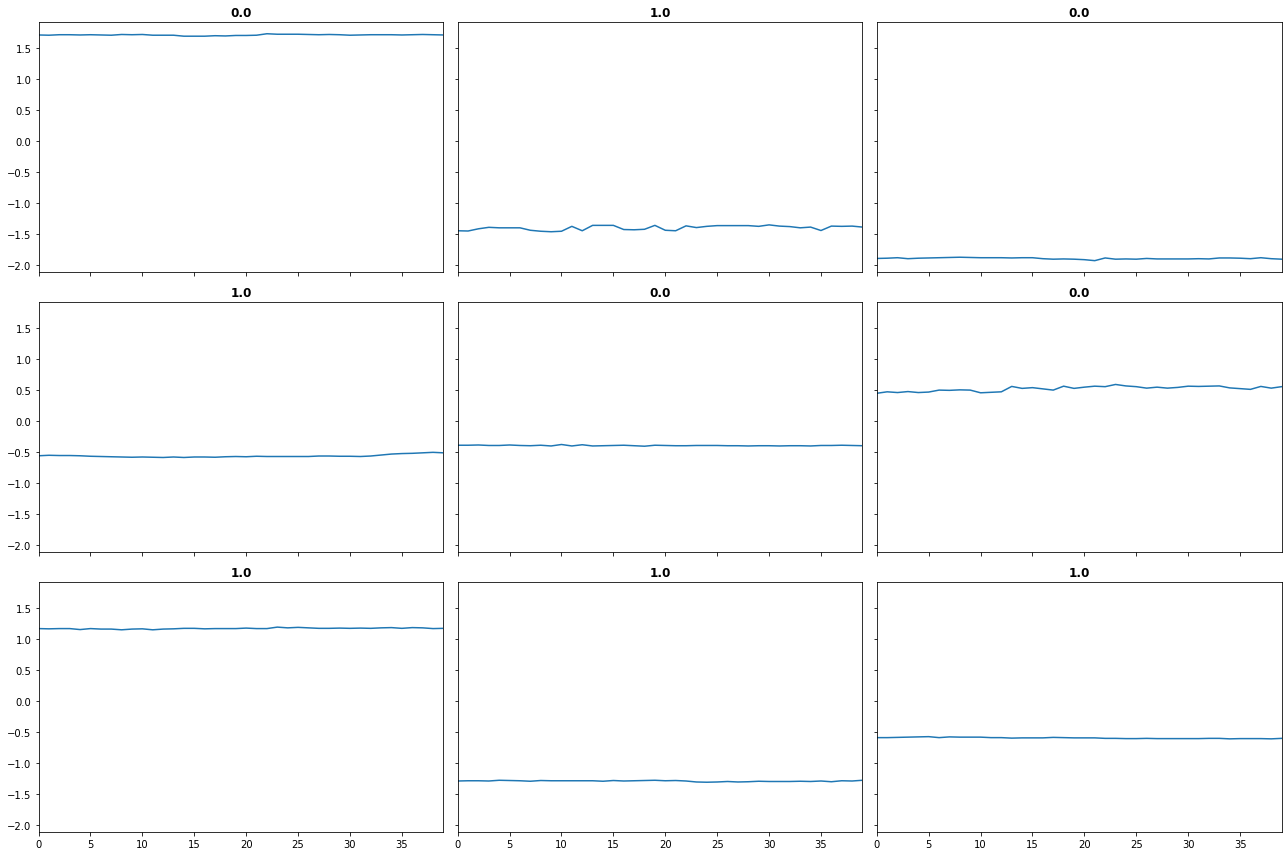

In [14]:
from tsai.all import *
import pandas as pd
from datenverarbeitung.dataloader import dataloader

num_scenario = 1
dl = dataloader(scenario= num_scenario, path="/home/adi/cloudy_adlu/smart_hans/AP2/Daten/headpose_opencv_pitch_roll_yaw_20220904", nr_taps=1, move_window_by=-10, index_datapoint = 2)
train, test, df_labled = dl.get_train_test(frac = 0.8, seed = 0)

X_train, y_train = df2xy(train, target_col='target')
X_test, y_test = df2xy(test, target_col='target')

X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

# X_train, y_train = df2xy(train_df, target_col='target')
# np.shape(X)
# test_eq(X_test.shape, (60, 1, 40))
# test_eq(y_test.shape, (60, ))

tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

dls.show_batch(sharey=True)

In [15]:
scenario_name_stage0 = "scenario_{}_stage0".format(num_scenario)
model = InceptionTime(dls.vars, dls.c)
learn = ts_learner(dls, model, metrics=accuracy, train_metrics=True)
learn.save(scenario_name_stage0)

Path('models/scenario3_stage0.pth')

SuggestedLRs(valley=0.0010000000474974513)

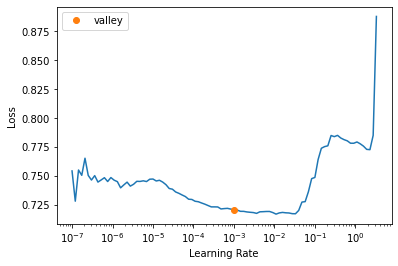

In [16]:
learn.load(scenario_name_stage0)
learn.lr_find()

In [20]:
scenario_name_stage1 = scenario_name_stage0.replace("0","1")
learn.fit_one_cycle(100, lr_max=1e-3)
learn.save(scenario_name_stage1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.690759,0.536458,0.746832,0.360656,00:00
1,0.689293,0.541667,0.748188,0.360656,00:00
2,0.691522,0.510417,0.747369,0.360656,00:01
3,0.690148,0.552083,0.746551,0.360656,00:00
4,0.690180,0.510417,0.746648,0.360656,00:00
5,0.688736,0.578125,0.746011,0.360656,00:01
6,0.688638,0.526042,0.744826,0.360656,00:00
7,0.688384,0.531250,0.745718,0.360656,00:00
8,0.688073,0.578125,0.747203,0.360656,00:00
9,0.687789,0.541667,0.752355,0.360656,00:00


Path('models/scenario3_stage0.pth')

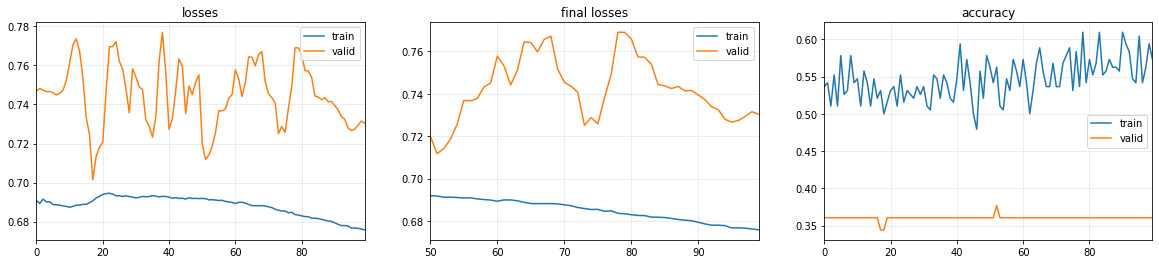

In [21]:
learn.recorder.plot_metrics()

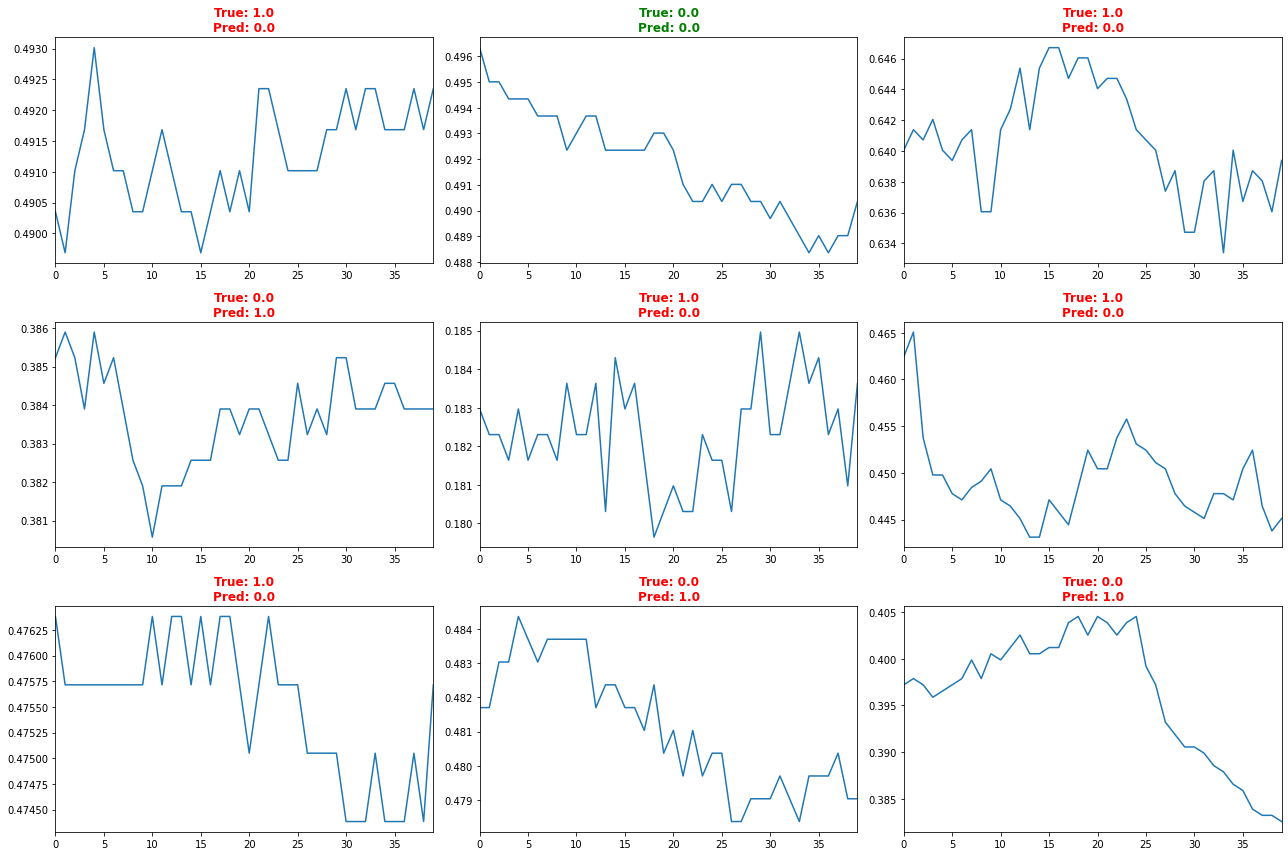

In [19]:
learn.show_results()

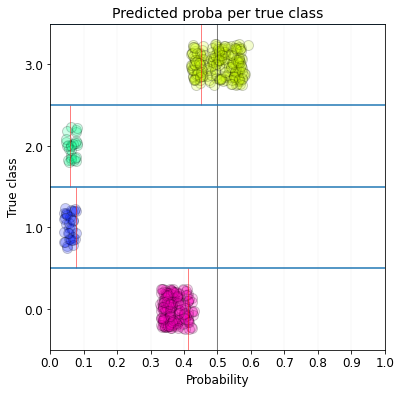

In [11]:
learn.show_probas()
#was sagt probability aus? accuracy vs probability?

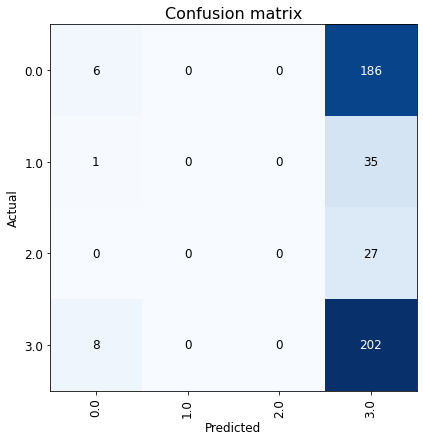

In [12]:
learn.plot_confusion_matrix()

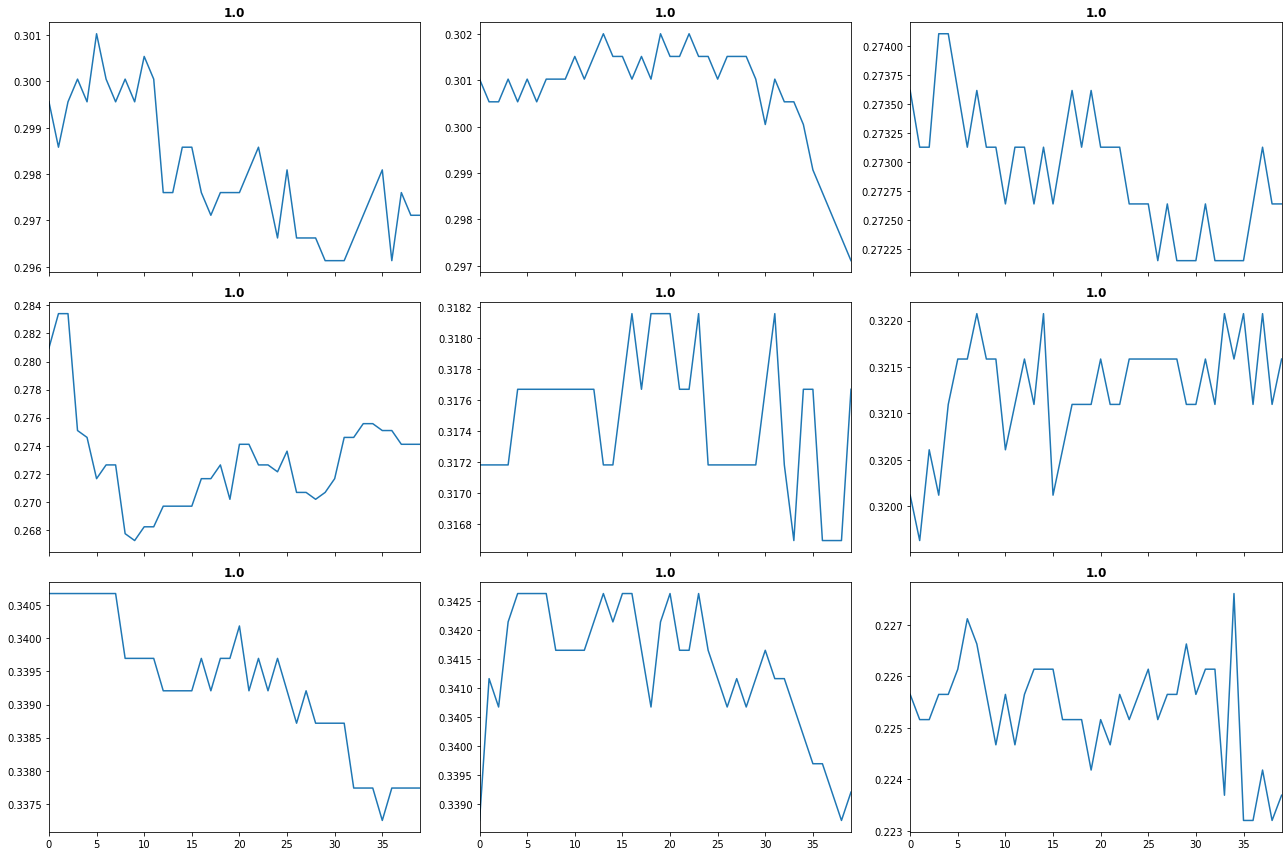

In [13]:
learn.plot_top_losses(X[splits[1]], y[splits[1]], largest=True)